In [1]:
%load_ext autoreload
%autoreload 2

import qubx

%qubxd
import pandas as pd
import numpy as np

from qubx._nb_magic import *
from qubx.data.helpers import loader
from qubx.data.hft import HftDataReader

from qubx.core.metrics import tearsheet
from qubx.backtester.simulator import simulate
from qubx.core.metrics import chart_signals
from qubx.data.readers import AsTrades

from qubx.utils.misc import add_project_to_system_path

add_project_to_system_path("~/devs/Qubx")

from tests.strategies.obi_trader.models.obi_trader import ObiTraderStrategy
from qubx import logger, QubxLogConfig


QubxLogConfig.set_log_level("DEBUG")


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.1
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


### 1. Check HFT reader separately

In [2]:
reader = HftDataReader()

In [17]:
iterator = reader.read(
    "BINANCE.UM:BTCUSDT",
    start="2025-01-01",
    stop="2025-01-02",
    # start="2025-01-02",
    # stop="2025-01-03",
    data_type="orderbook"
)

In [23]:
reader.close()

In [19]:
list(reader._prefetchers.values())[0].queues["orderbook"].qsize()

0

In [21]:
chunk = next(iterator)

In [22]:
pd.Timestamp(chunk[0][0])

Timestamp('2025-01-01 01:23:22.999000')

In [ ]:
quote_iterator = reader.read("BINANCE.UM:BTCUSDT", start="2025-01-01", stop="2025-01-02", data_type="quote")

In [12]:
quote_chunk = next(quote_iterator)

In [13]:
quote_chunk[0]

(1735689601999000000, 93548.7, 93548.8, 0.953, 5.474)

In [14]:
trade_iterator = reader.read(
    "BINANCE.UM:BTCUSDT",
    start="2025-01-01",
    stop="2025-01-02",
    data_type="trade",
    transform=AsTrades(),
)

In [16]:
trade_chunk = next(trade_iterator)

In [18]:
len(trade_chunk)

4882

In [22]:
trade_chunk[:10]

[TradeArray(size=2, volume=0.1, buys=0.1, sells=0.0),
 TradeArray(size=314, volume=20.1, buys=2.1, sells=18.0),
 TradeArray(size=43, volume=1.0, buys=0.3, sells=0.7),
 TradeArray(size=36, volume=1.9, buys=0.1, sells=1.8),
 TradeArray(size=15, volume=1.8, buys=0.0, sells=1.7),
 TradeArray(size=11, volume=0.8, buys=0.1, sells=0.7),
 TradeArray(size=5, volume=0.1, buys=0.0, sells=0.0),
 TradeArray(size=17, volume=0.5, buys=0.1, sells=0.3),
 TradeArray(size=10, volume=0.1, buys=0.0, sells=0.1),
 TradeArray(size=8, volume=0.1, buys=0.0, sells=0.1)]

### 2. Run simulation

2025-03-05 10:28:19.588 [ 🐞 ] (helpers) ObiTraderStrategy new parameters:
	set tick_size_pct <- 0.1
	set depth <- 25
	set threshold <- 0.5


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
Test,1128.992,13503.114,15.065,10.401,9.601,172.039,59.795,317717.972,2.962,0.979,28.284,2.694,0.0,5117.0


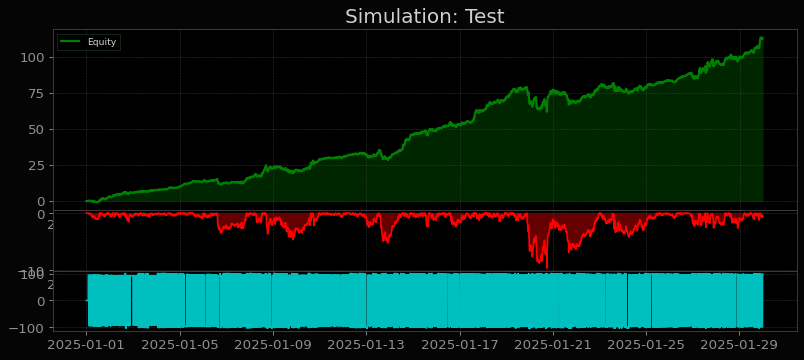

In [2]:
r = simulate(
    strategies={"Test": (stg1 := ObiTraderStrategy(tick_size_pct=0.1, depth=25, threshold=0.5))},
    data=HftDataReader(enable_quote=False),
    capital=1000,
    instruments=["BINANCE.UM:BTCUSDT"],
    commissions=None,
    start="2025-01-01",
    stop="2025-01-30",
    portfolio_log_freq="1min",
    debug="WARNING",
)
tearsheet(r, plot_leverage=True)